# HandsOn : OpenMM alanine dipeptide

A simulation of the famous alanine dipeptide using OpenMM.
* use `.xml` files from OpenMM
* use `topol.top` files from GROMACS

Let's import every thing we need.

But this time import not everything from the module, so we can use `<tab>` to check what is in `app.` or `mm.`.

In [1]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk.unit import *

# Setup the Simulation

1. Read the PDB file to extract the topology and the positions from it.
2. Load the `*.xml` file for the force field.
3. Create the system
4. Define the integrator.
5. Create the simulation context
6. Set positions of the context

In [2]:
# read the pdb file
pdb = app.PDBFile("alanine_dipeptide_solvated.pdb")

# read the force field file
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')

# Create the system
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)

# define the integrator
integrator = mm.LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

# create the simulation context
simulation = app.Simulation(pdb.topology, system, integrator)

# set the positions
simulation.context.setPositions(pdb.positions)

Note: Force field files from the current directory are taken first, then from the OpenMM install directory

You can see files with:
```python
import os
from pprint import pformat

path_xml_files = os.path.join(app.__path__[0], 'data')
print("XML files are located here:\n {}".format(path_xml_files))
print("XML files :\n", pformat(os.listdir(path_xml_files)))
```

## Minimize the energy

first check the current energy of the system

In [3]:
state = simulation.context.getState(getEnergy=True)
print("PE : {}".format(state.getPotentialEnergy()))

PE : -21828.132261735016 kJ/mol


minimize the system

In [4]:
simulation.minimizeEnergy()

In [5]:
state = simulation.context.getState(getEnergy=True)
print("PE : {}".format(state.getPotentialEnergy()))

PE : -27326.22315019231 kJ/mol


## Simulation

add reporters to store the data

In [6]:
# report thermodynamical properties
simulation.reporters.append(app.StateDataReporter('thermo.csv', 100,
                                                  step=True, potentialEnergy=True, temperature=True))
# report positions
simulation.reporters.append(app.DCDReporter('trajectory.dcd', 100))

generate velocities

In [7]:
simulation.context.setVelocitiesToTemperature(300*kelvin)

run the simulation

In [8]:
simulation.step(10000)

## Analysis

In [9]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

get the header of `thermo.csv`

In [10]:
open('thermo.csv', 'r').readline()

'#"Step","Potential Energy (kJ/mole)","Temperature (K)"\n'

Read in the CSV file and assign the column names to fields in the `numpy.array`

In [11]:
csv = np.genfromtxt('thermo.csv', delimiter=',', names=True)
print("Fields : {}".format(csv.dtype.names))

Fields : ('Step', 'Potential_Energy_kJmole', 'Temperature_K')


Text(0, 0.5, 'Potential Energy [kJ/mole]')

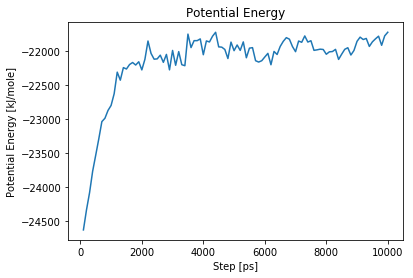

In [12]:
plt.title('Potential Energy')

plt.plot(csv['Step'], csv['Potential_Energy_kJmole'])

plt.xlabel('Step [ps]')
plt.ylabel('Potential Energy [kJ/mole]')

# Starting a simulation using GROMACS files

## Preperation (GROMACS)

To make things easy we just copy the force field in this folder.
```bash
cp ${GMXDATA}/top/amber96.ff .
```

Due to naming conventions of GROMACS we have to change the naming of the `ACE` and `NME` residue
```bash
sed '
  s/ H1  ACE/HH31 ACE/; 
  s/ H2  ACE/HH32 ACE/; 
  s/ H3  ACE/HH33 ACE/; 
  s/ H1  NME/HH31 NME/; 
  s/ H2  NME/HH32 NME/; 
  s/ H3  NME/HH33 NME/;
  s/ C   NME/CH3  NME/;
  s/ O   HOH/OW   HOH/g;
  s/ H1  HOH/HW1  HOH/g;
  s/ H2  HOH/HW2  HOH/g;

  ' alanine_dipeptide_solvated.pdb > alanine_dipeptide_solvated_gromacs.pdb
```

Then we create the needed top file.
```bash
gmx pdb2gmx -f alanine_dipeptide_solvated.pdb -water tip3p -ff amber96
```

Let's read in the pdb file again, you could also use
```python
gro = app.GromacsGroFile("my_awesome_system.gro")
# box_vectors = gro.getPeriodicBoxVectors()
```
to read `.gro` files.

In [13]:
# read the pdb file
pdb = app.PDBFile("alanine_dipeptide_solvated_gromacs.pdb")

This time we want to get the topology from the gromacs top file

In [14]:
top = app.GromacsTopFile('topol.top',
          periodicBoxVectors=pdb.topology.getPeriodicBoxVectors(),
          includeDir='amber96.ff')

Create a system

In [15]:
system = top.createSystem(
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005)

Now create the rest

In [16]:
# define the integrator
integrator = mm.LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)

# create the simulation context
simulation = app.Simulation(top.topology, system, integrator)

# set the positions
simulation.context.setPositions(pdb.positions)

We are ready to go now and just created a simulation context from GROMACS input files.

# Compare both

In [17]:
import mdtraj

Let's just use the topology from OpenMM !

In [18]:
trajectory = mdtraj.load('trajectory.dcd',
                         top=mdtraj.Topology.from_openmm(simulation.topology))

Let's use the positions of the old trajectory for the calculation of energies

In [19]:
# Storage for energies
potential_energy_gromacs = []

for i in range(trajectory.n_frames):
    # get the coordinates (MDTRAJ reads them as nanometers)
    coordinates = trajectory.xyz[i] * nanometer # Important!
    
    # set the new positions
    simulation.context.setPositions(coordinates)
    
    # define the state
    state = simulation.context.getState(getEnergy=True)
    # get the potential energy
    pe = state.getPotentialEnergy()
    
    # only get the value in kJ/mole
    potential_energy_gromacs.append( pe.value_in_unit(kilojoule / mole) )

Compare the `OpenMM` `.xml` files with the `GROMACS` files

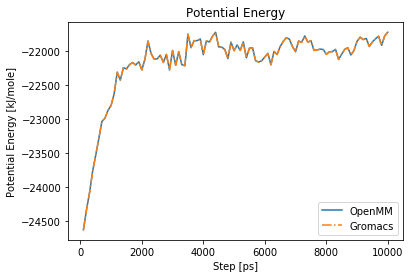

In [20]:
plt.title('Potential Energy')

plt.plot(csv['Step'], csv['Potential_Energy_kJmole'], label='OpenMM')
plt.plot(csv['Step'], potential_energy_gromacs, '-.', label='Gromacs')


plt.xlabel('Step [ps]')
plt.ylabel('Potential Energy [kJ/mole]')
plt.legend()

Looks good!

In [23]:
np.testing.assert_array_almost_equal(csv['Potential_Energy_kJmole'], potential_energy_gromacs)

AssertionError: 
Arrays are not almost equal to 6 decimals

(mismatch 100.0%)
 x: array([-24632.105963, -24336.53565 , -24083.53565 , -23768.293463,
       -23531.5044  , -23291.09815 , -23037.113775, -22987.590338,
       -22872.277838, -22798.824713, -22626.184088, -22308.520025,...
 y: array([-24633.84823 , -24338.259431, -24085.243806, -23770.025056,
       -23533.228181, -23292.821931, -23038.853181, -22989.321931,
       -22873.993806, -22800.540681, -22627.915681, -22310.228181,...

There are still small differences !

Both have parameters converted from AMBER.

Different precision in saved parameters:
* OpenMM : `amber96.xml` -> sigma = `.12f`
* GROMACS : `amber96.ff` -> sigma = `.5e`

Maybe also other differences ... Who knows what people did?